In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, \
    confusion_matrix, ConfusionMatrixDisplay 

In [2]:
df_train = pd.read_csv('train.csv')

df_test =  pd.read_csv('test.csv')

In [3]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print("df_train shape:", df_train.shape)  
print("df_test shape: ", df_test.shape) 

df_train shape: (42000, 785)
df_test shape:  (28000, 784)


In [5]:
print(
    "Missing values in df_train: ", \
    df_train.isna().sum().sum()
)
print(
    "Missing values in df_test: ", \
    df_test.isna().sum().sum()
)

Missing values in df_train:  0
Missing values in df_test:  0


In [6]:
X_train = df_train.drop(columns=['label']).values
y_train = df_train['label'].values

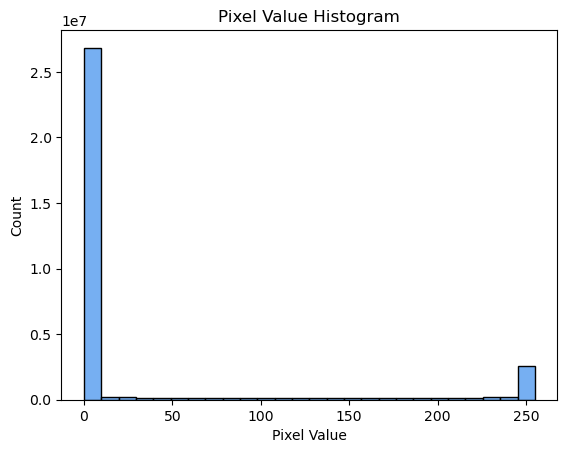

In [7]:
ax = sns.histplot(x=X_train.flatten(), color='#4895EE')
_ = ax.set(title='Pixel Value Histogram', xlabel='Pixel Value')


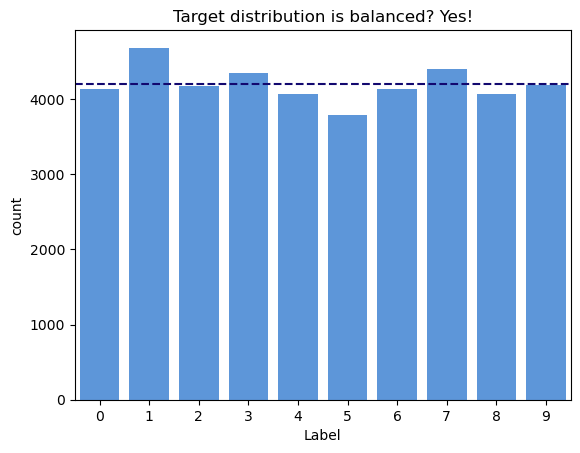

In [8]:
ax = sns.countplot(x=y_train, color='#4895EE')
ax.set(title='Target distribution is balanced? Yes!',xlabel='Label')
_ = ax.axhline(y=4200, color='#12086F', linestyle='--')

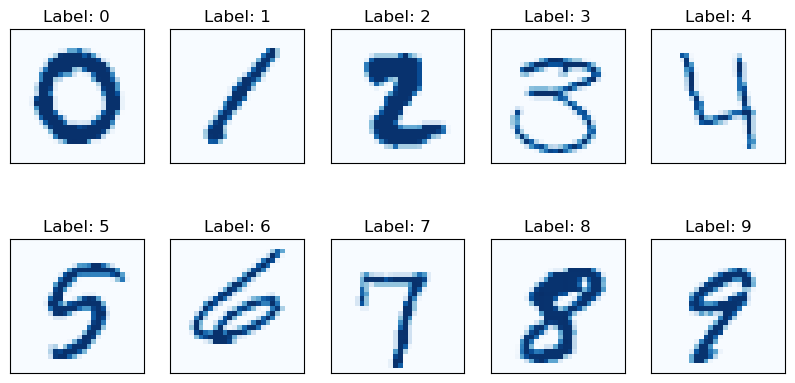

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10,5))

for i in range(10):
    idx = np.where(y_train==i)[0][0]
    img = axs[int(i >= 5), i%5].imshow(
        X=X_train[idx].reshape(28, 28),
        cmap='Blues'
    )
    img.axes.get_yaxis().set_visible(False)
    img.axes.get_xaxis().set_visible(False)
    img.axes.set_title(f'Label: {i}')

In [10]:
print("Before applying MinMax Scaler:")
print("  - Minimum value:", X_train.min())
print("  - Maximum value:", X_train.max())

minmax_scaler = MinMaxScaler()
X_train_scaled = minmax_scaler.fit_transform(X_train)

print("\nAfter applying MinMax Scaler:")
print("  - Minimum value:", X_train_scaled.min())
print("  - Maximum value:", X_train_scaled.max())

Before applying MinMax Scaler:
  - Minimum value: 0
  - Maximum value: 255

After applying MinMax Scaler:
  - Minimum value: 0.0
  - Maximum value: 1.0


In [11]:
pca = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=10))
])

X_train_pca = pca.fit_transform(X=X_train)

print('X_train_pca shape:', X_train_pca.shape)

X_train_pca shape: (42000, 10)


In [12]:
X_train_pca[0]

array([-2.59449322, -2.74239783,  0.71874945,  0.47298705, -0.31797762,
        1.91944821, -2.68026346,  0.33510311,  1.36715946,  0.79617459])

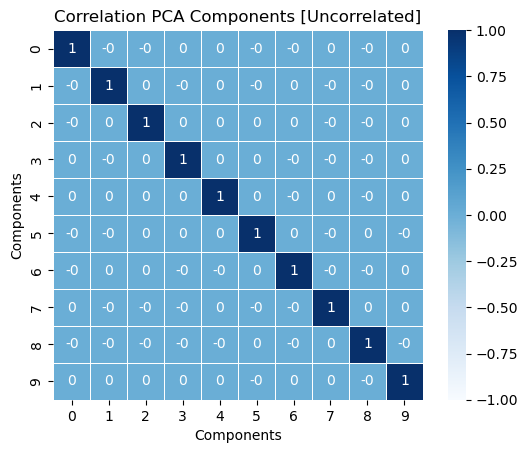

In [13]:

corr = np.corrcoef(x=X_train_pca, rowvar=False)
corr = np.around(corr, decimals=2)

ax = sns.heatmap(
    data=corr, 
    vmax=1, 
    vmin=-1,
    square=True,
    linewidths=.5,
    annot=True,
    cmap='Blues',
)

_ = ax.set(
    title='Correlation PCA Components [Uncorrelated]',
    xlabel='Components',
    ylabel='Components'
)

# without feature selection

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the pipeline
svm_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=10)),
    ('svm', SVC())
])

# Define the parameter grid
svm_clf_params = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': [ 'rbf'],
    'svm__gamma': ['scale', 'auto']  
}

# Set up the GridSearchCV
svm_clf_gs = GridSearchCV(
    estimator=svm_clf, 
    param_grid=svm_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

# Fit the model
svm_clf_gs.fit(X=X_train, y=y_train)

# Print the best parameters and the best score
print('best PCA+SVM params:', svm_clf_gs.best_params_)
print('best PCA+SVM cv accuracy:', svm_clf_gs.best_score_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
best PCA+SVM params: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
best PCA+SVM cv accuracy: 0.9410000000000001


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the pipeline
knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=50)),
    ('rfe', RFE(estimator=LogisticRegression(), step=1)),
    ('svm', SVC())
])

# Define the parameter grid
knn_clf_params = {
    'rfe__n_features_to_select': [ 10, 20], 
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['rbf'],
    'svm__gamma': ['scale', 'auto']
}

# Define the GridSearchCV
knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

# Fit the GridSearchCV
knn_clf_gs.fit(X_train, y_train)

# Print the best parameters and best cross-validation score
print('Best RFE+PCA+SVM params:', knn_clf_gs.best_params_)
print('Best RFE+PCA+SVM cv accuracy:', knn_clf_gs.best_score_)



Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best RFE+PCA+SVM params: {'rfe__n_features_to_select': 20, 'svm__C': 10, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Best RFE+PCA+SVM cv accuracy: 0.9735238095238096


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=10)),
    ('lasso', SelectFromModel(Lasso())),
    ('svm', SVC())
])

knn_clf_params = {
    'lasso__estimator__alpha': [0.1, 0.5, 1.0],  # Adjust regularization strength
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['rbf'],
    'svm__gamma': ['scale', 'auto']
}

knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

knn_clf_gs.fit(X=X_train, y=y_train)

print('best PCA+Lasso+KNN params:', knn_clf_gs.best_params_)
print('best PCA+Lasso+KNN cv accuracy:', knn_clf_gs.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
best PCA+Lasso+KNN params: {'lasso__estimator__alpha': 0.1, 'svm__C': 1, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
best PCA+Lasso+KNN cv accuracy: 0.9087142857142858


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the pipeline
knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=10)),
    ('f_classif', SelectKBest(f_classif)),
    ('svm', SVC())
])

# Define the parameter grid
knn_clf_params = {
    'f_classif__k': [5, 10],  # Adjust the number of features to select
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['rbf'],
    'svm__gamma': ['scale', 'auto']
}

# Define the GridSearchCV
knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

# Fit the GridSearchCV
knn_clf_gs.fit(X=X_train, y=y_train)

# Print the best parameters and best cross-validation score
print('Best PCA+F_Classif+KNN params:', knn_clf_gs.best_params_)
print('Best PCA+F_Classif+KNN cv accuracy:', knn_clf_gs.best_score_)



Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best PCA+F_Classif+KNN params: {'f_classif__k': 10, 'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best PCA+F_Classif+KNN cv accuracy: 0.9410000000000001


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import FastICA
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the pipeline
knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('ica', FastICA(n_components=10)),  # Adjust number of components as needed
    ('rfe', RFE(estimator=RandomForestClassifier())),
    ('svm', SVC())
])

# Define the parameter grid
knn_clf_params = {
    'rfe__n_features_to_select': [5, 10, 15],  # Adjust as needed
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['rbf'],
    'svm__gamma': ['scale', 'auto']
}

# Define the GridSearchCV
knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

# Fit the GridSearchCV
knn_clf_gs.fit(X=X_train, y=y_train)

# Print the best parameters and best cross-validation score
print('Best ICA+RFE+KNN params:', knn_clf_gs.best_params_)
print('Best ICA+RFE+KNN cv accuracy:', knn_clf_gs.best_score_)



Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best ICA+RFE+KNN params: {'rfe__n_features_to_select': 15, 'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best ICA+RFE+KNN cv accuracy: 0.8327142857142856


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import FastICA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('ica', FastICA(n_components=10)),  # Adjust number of components as needed
    ('select_k_best', SelectKBest(score_func=f_classif)),
    ('svm', SVC())
])

knn_clf_params = {
    'select_k_best__k': [5, 7, 10],  # Adjust the range of k values
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['rbf'],
    'svm__gamma': ['scale', 'auto']
}


knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

knn_clf_gs.fit(X=X_train, y=y_train)

print('Best ICA+SelectKBest+KNN params:', knn_clf_gs.best_params_)
print('Best ICA+SelectKBest+KNN cv accuracy:', knn_clf_gs.best_score_)



Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Best ICA+SelectKBest+KNN params: {'select_k_best__k': 10, 'svm__C': 100, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Best ICA+SelectKBest+KNN cv accuracy: 0.8312380952380952


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import FastICA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('ica', FastICA(n_components=10)),  # Adjust number of components as needed
    ('feature_selection', SelectKBest(f_classif)),
    ('svm', SVC())
])

knn_clf_params = {
    'feature_selection__k': [5, 10],  # Adjust the number of features to select
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['rbf'],
    'svm__gamma': ['scale', 'auto']
}

knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

knn_clf_gs.fit(X=X_train, y=y_train)

print('best ICA+f_classif+KNN params:', knn_clf_gs.best_params_)
print('best ICA+f_classif+KNN cv accuracy:', knn_clf_gs.best_score_)



Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


best ICA+f_classif+KNN params: {'feature_selection__k': 10, 'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
best ICA+f_classif+KNN cv accuracy: 0.8313809523809524


In [18]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.base import BaseEstimator, TransformerMixin

class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, input_dim, encoding_dim):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.encoder = None

    def fit(self, X, y=None):
        # Create the MLP model
        self.encoder = MLPRegressor(hidden_layer_sizes=(self.encoding_dim,), activation='relu', max_iter=200, solver='adam')
        self.encoder.fit(X, X)
        return self

    def transform(self, X):
        # Use the trained MLP to encode the input data
        encoded_X = self.encoder.predict(X)
        return encoded_X

# Example dataset
# You should replace X_train and y_train with your actual dataset
from sklearn.datasets import make_classification
X_train, y_train = make_classification(n_samples=1000, n_features=20, random_state=42)

autoencoder = AutoencoderTransformer(input_dim=X_train.shape[1], encoding_dim=10)  # Adjust encoding_dim as needed

knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('autoencoder', autoencoder),
    ('rfe', RFE(estimator=LogisticRegression())),
    ('svm', SVC())
])

knn_clf_params = {
    'rfe__n_features_to_select': [5, 10, 15],  # Adjust as needed
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['rbf'],
    'svm__gamma': ['scale', 'auto']
}

knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

knn_clf_gs.fit(X=X_train, y=y_train)

print('best Autoencoder+RFE+KNN params:', knn_clf_gs.best_params_)
print('best Autoencoder+RFE+KNN cv accuracy:', knn_clf_gs.best_score_)



Fitting 5 folds for each of 24 candidates, totalling 120 fits
best Autoencoder+RFE+KNN params: {'rfe__n_features_to_select': 5, 'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
best Autoencoder+RFE+KNN cv accuracy: 0.7310000000000001


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPRegressor
import numpy as np

class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, input_dim, encoding_dim):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.autoencoder = None

    def fit(self, X, y=None):
        self.autoencoder = MLPRegressor(hidden_layer_sizes=(self.encoding_dim,),
                                        activation='relu',
                                        solver='adam',
                                        max_iter=50,
                                        random_state=42)
        self.autoencoder.fit(X, X)
        return self

    def transform(self, X):
        encoded_X = self.autoencoder.predict(X)
        return encoded_X

autoencoder = AutoencoderTransformer(input_dim=X_train.shape[1], encoding_dim=10)  # Adjust encoding_dim as needed

knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('autoencoder', autoencoder),
    ('lasso', SelectFromModel(Lasso())),
    ('svm', SVC())
])

knn_clf_params = {
    'lasso__estimator__alpha': [0.1, 0.5, 1.0],  # Adjust regularization strength
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': [ 'rbf'],
    'svm__gamma': ['scale', 'auto']
}

knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

# Assuming X_train and y_train are properly defined
knn_clf_gs.fit(X_train, y_train)

print('best Autoencoder+Lasso+KNN params:', knn_clf_gs.best_params_)
print('best Autoencoder+Lasso+KNN cv accuracy:', knn_clf_gs.best_score_)




Fitting 5 folds for each of 24 candidates, totalling 120 fits


ValueError: 
All the 120 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1147, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 978, in check_array
    raise ValueError(
ValueError: Found array with 0 feature(s) (shape=(800, 0)) while a minimum of 1 is required by SVC.


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.base import BaseEstimator, TransformerMixin

class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, input_dim, encoding_dim):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.autoencoder = None

    def fit(self, X, y=None):
        self.autoencoder = MLPRegressor(hidden_layer_sizes=(self.encoding_dim,),
                                        activation='relu',
                                        solver='adam',
                                        max_iter=50,
                                        random_state=42)
        self.autoencoder.fit(X, X)
        return self

    def transform(self, X):
        encoded_X = self.autoencoder.predict(X)
        return encoded_X

autoencoder = AutoencoderTransformer(input_dim=X_train.shape[1], encoding_dim=10)  # Adjust encoding_dim as needed

knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('autoencoder', autoencoder),
    ('select_k_best', SelectKBest(f_classif)),
    ('svm', SVC())
])

knn_clf_params = {
    'select_k_best__k': [5, 10, 15],  # Adjust the number of features to select
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': [ 'rbf'],
    'svm__gamma': ['scale', 'auto']
}

knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

knn_clf_gs.fit(X=X_train, y=y_train)

print('best Autoencoder+SelectKBest+KNN params:', knn_clf_gs.best_params_)
print('best Autoencoder+SelectKBest+KNN cv accuracy:', knn_clf_gs.best_score_)




Fitting 5 folds for each of 24 candidates, totalling 120 fits
best Autoencoder+SelectKBest+KNN params: {'select_k_best__k': 5, 'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
best Autoencoder+SelectKBest+KNN cv accuracy: 0.609


C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


# without feature selection

In [22]:
from sklearn.svm import SVC
svm_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=10)),
    ('svm', SVC())
])

knn_clf_params = {'svm__C': [0.1, 1, 10]}

knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

knn_clf_gs.fit(X=X_train, y=y_train)

print('best PCA+KNN params:', knn_clf_gs.best_params_)
print('best PCA+KNN cv accuracy:', knn_clf_gs.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


ValueError: Invalid parameter 'svm' for estimator Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=50)),
                ('rfe', RFE(estimator=LogisticRegression())),
                ('knn', KNeighborsClassifier())]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the pipeline
knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=50)),
    ('rfe', RFE(estimator=LogisticRegression(), step=1)),
    ('knn', KNeighborsClassifier())
])

# Define the parameter grid
knn_clf_params = {
    'rfe__n_features_to_select': [ 10, 0], 
    'knn__n_neighbors': [  10,20]
}

# Define the GridSearchCV
knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

# Fit the GridSearchCV
knn_clf_gs.fit(X_train, y_train)

# Print the best parameters and best cross-validation score
print('Best RFE+PCA+KNN params:', knn_clf_gs.best_params_)
print('Best RFE+PCA+KNN cv accuracy:', knn_clf_gs.best_score_)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best RFE+PCA+KNN params: {'knn__n_neighbors': 10, 'rfe__n_features_to_select': 50}
Best RFE+PCA+KNN cv accuracy: 0.9698095238095238


C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=10)),
    ('lasso', SelectFromModel(Lasso())),
    ('knn', KNeighborsClassifier())
])

knn_clf_params = {
    'lasso__estimator__alpha': [0.1, 0.5, 1.0],  # Adjust regularization strength
    'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

knn_clf_gs.fit(X=X_train, y=y_train)

print('best PCA+Lasso+KNN params:', knn_clf_gs.best_params_)
print('best PCA+Lasso+KNN cv accuracy:', knn_clf_gs.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
3 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 416, in fit
    Xt = self._fit(X, y, **fit

best PCA+Lasso+KNN params: {'knn__n_neighbors': 9, 'lasso__estimator__alpha': 0.1}
best PCA+Lasso+KNN cv accuracy: 0.8938095238095236


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the pipeline
knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=10)),
    ('f_classif', SelectKBest(f_classif)),
    ('knn', KNeighborsClassifier())
])

# Define the parameter grid
knn_clf_params = {
    'f_classif__k': [5, 10],  # Adjust the number of features to select
    'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

# Define the GridSearchCV
knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

# Fit the GridSearchCV
knn_clf_gs.fit(X=X_train, y=y_train)

# Print the best parameters and best cross-validation score
print('Best PCA+F_Classif+KNN params:', knn_clf_gs.best_params_)
print('Best PCA+F_Classif+KNN cv accuracy:', knn_clf_gs.best_score_)



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best PCA+F_Classif+KNN params: {'f_classif__k': 10, 'knn__n_neighbors': 9}
Best PCA+F_Classif+KNN cv accuracy: 0.9240714285714287


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import FastICA
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the pipeline
knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('ica', FastICA(n_components=10)),  # Adjust number of components as needed
    ('rfe', RFE(estimator=RandomForestClassifier())),
    ('knn', KNeighborsClassifier())
])

# Define the parameter grid
knn_clf_params = {
    'rfe__n_features_to_select': [5, 10, 15],  # Adjust as needed
    'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

# Define the GridSearchCV
knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

# Fit the GridSearchCV
knn_clf_gs.fit(X=X_train, y=y_train)

# Print the best parameters and best cross-validation score
print('Best ICA+RFE+KNN params:', knn_clf_gs.best_params_)
print('Best ICA+RFE+KNN cv accuracy:', knn_clf_gs.best_score_)



Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best ICA+RFE+KNN params: {'knn__n_neighbors': 10, 'rfe__n_features_to_select': 15}
Best ICA+RFE+KNN cv accuracy: 0.8093571428571428


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import FastICA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('ica', FastICA(n_components=10)),  # Adjust number of components as needed
    ('select_k_best', SelectKBest(score_func=f_classif)),
    ('knn', KNeighborsClassifier())
])

knn_clf_params = {
    'select_k_best__k': [5, 7, 10],  # Adjust the range of k values
    'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}


knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

knn_clf_gs.fit(X=X_train, y=y_train)

print('Best ICA+SelectKBest+KNN params:', knn_clf_gs.best_params_)
print('Best ICA+SelectKBest+KNN cv accuracy:', knn_clf_gs.best_score_)



Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best ICA+SelectKBest+KNN params: {'knn__n_neighbors': 8, 'select_k_best__k': 10}
Best ICA+SelectKBest+KNN cv accuracy: 0.8081190476190476


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import FastICA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('ica', FastICA(n_components=10)),  # Adjust number of components as needed
    ('feature_selection', SelectKBest(f_classif)),
    ('knn', KNeighborsClassifier())
])

knn_clf_params = {
    'feature_selection__k': [5, 10],  # Adjust the number of features to select
    'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

knn_clf_gs.fit(X=X_train, y=y_train)

print('best ICA+f_classif+KNN params:', knn_clf_gs.best_params_)
print('best ICA+f_classif+KNN cv accuracy:', knn_clf_gs.best_score_)



Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


best ICA+f_classif+KNN params: {'feature_selection__k': 10, 'knn__n_neighbors': 10}
best ICA+f_classif+KNN cv accuracy: 0.8091666666666667


In [22]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.base import BaseEstimator, TransformerMixin

class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, input_dim, encoding_dim):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.encoder = None

    def fit(self, X, y=None):
        # Create the MLP model
        self.encoder = MLPRegressor(hidden_layer_sizes=(self.encoding_dim,), activation='relu', max_iter=200, solver='adam')
        self.encoder.fit(X, X)
        return self

    def transform(self, X):
        # Use the trained MLP to encode the input data
        encoded_X = self.encoder.predict(X)
        return encoded_X

# Example dataset
# You should replace X_train and y_train with your actual dataset
from sklearn.datasets import make_classification
X_train, y_train = make_classification(n_samples=1000, n_features=20, random_state=42)

autoencoder = AutoencoderTransformer(input_dim=X_train.shape[1], encoding_dim=10)  # Adjust encoding_dim as needed

knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('autoencoder', autoencoder),
    ('rfe', RFE(estimator=LogisticRegression())),
    ('knn', KNeighborsClassifier())
])

knn_clf_params = {
    'rfe__n_features_to_select': [5, 10, 15],  # Adjust as needed
    'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

knn_clf_gs.fit(X=X_train, y=y_train)

print('best Autoencoder+RFE+KNN params:', knn_clf_gs.best_params_)
print('best Autoencoder+RFE+KNN cv accuracy:', knn_clf_gs.best_score_)



Fitting 5 folds for each of 30 candidates, totalling 150 fits
best Autoencoder+RFE+KNN params: {'knn__n_neighbors': 7, 'rfe__n_features_to_select': 10}
best Autoencoder+RFE+KNN cv accuracy: 0.7


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPRegressor
import numpy as np

class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, input_dim, encoding_dim):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.autoencoder = None

    def fit(self, X, y=None):
        self.autoencoder = MLPRegressor(hidden_layer_sizes=(self.encoding_dim,),
                                        activation='relu',
                                        solver='adam',
                                        max_iter=50,
                                        random_state=42)
        self.autoencoder.fit(X, X)
        return self

    def transform(self, X):
        encoded_X = self.autoencoder.predict(X)
        return encoded_X

autoencoder = AutoencoderTransformer(input_dim=X_train.shape[1], encoding_dim=10)  # Adjust encoding_dim as needed

knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('autoencoder', autoencoder),
    ('lasso', SelectFromModel(Lasso())),
    ('knn', KNeighborsClassifier())
])

knn_clf_params = {
    'lasso__estimator__alpha': [0.1, 0.5, 1.0],  # Adjust regularization strength
    'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

# Assuming X_train and y_train are properly defined
knn_clf_gs.fit(X_train, y_train)

print('best Autoencoder+Lasso+KNN params:', knn_clf_gs.best_params_)
print('best Autoencoder+Lasso+KNN cv accuracy:', knn_clf_gs.best_score_)




Fitting 5 folds for each of 30 candidates, totalling 150 fits


ValueError: 
All the 150 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 228, in fit
    return self._fit(X, y)
           ^^^^^^^^^^^^^^^
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\neighbors\_base.py", line 456, in _fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1147, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 978, in check_array
    raise ValueError(
ValueError: Found array with 0 feature(s) (shape=(800, 0)) while a minimum of 1 is required by KNeighborsClassifier.


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.base import BaseEstimator, TransformerMixin

class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, input_dim, encoding_dim):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.autoencoder = None

    def fit(self, X, y=None):
        self.autoencoder = MLPRegressor(hidden_layer_sizes=(self.encoding_dim,),
                                        activation='relu',
                                        solver='adam',
                                        max_iter=50,
                                        random_state=42)
        self.autoencoder.fit(X, X)
        return self

    def transform(self, X):
        encoded_X = self.autoencoder.predict(X)
        return encoded_X

autoencoder = AutoencoderTransformer(input_dim=X_train.shape[1], encoding_dim=10)  # Adjust encoding_dim as needed

knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('autoencoder', autoencoder),
    ('select_k_best', SelectKBest(f_classif)),
    ('knn', KNeighborsClassifier())
])

knn_clf_params = {
    'select_k_best__k': [5, 10, 15],  # Adjust the number of features to select
    'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

knn_clf_gs.fit(X=X_train, y=y_train)

print('best Autoencoder+SelectKBest+KNN params:', knn_clf_gs.best_params_)
print('best Autoencoder+SelectKBest+KNN cv accuracy:', knn_clf_gs.best_score_)




Fitting 5 folds for each of 30 candidates, totalling 150 fits
best Autoencoder+SelectKBest+KNN params: {'knn__n_neighbors': 3, 'select_k_best__k': 5}
best Autoencoder+SelectKBest+KNN cv accuracy: 0.575


C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.base import BaseEstimator, TransformerMixin

class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, input_dim, encoding_dim):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.autoencoder = None

    def fit(self, X, y=None):
        self.autoencoder = MLPRegressor(hidden_layer_sizes=(self.encoding_dim,),
                                        activation='relu',
                                        solver='adam',
                                        max_iter=50,
                                        random_state=42)
        self.autoencoder.fit(X, X)
        return self

    def transform(self, X):
        encoded_X = self.autoencoder.predict(X)
        return encoded_X

autoencoder = AutoencoderTransformer(input_dim=X_train.shape[1], encoding_dim=10)  # Adjust encoding_dim as needed

knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('autoencoder', autoencoder),
    ('select_k_best', SelectKBest(f_classif)),
    ('knn', KNeighborsClassifier())
])

knn_clf_params = {
    'select_k_best__k': [5, 10, 15],  # Adjust the number of features to select
    'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

knn_clf_gs.fit(X=X_train, y=y_train)

print('best Autoencoder+SelectKBest+KNN params:', knn_clf_gs.best_params_)
print('best Autoencoder+SelectKBest+KNN cv accuracy:', knn_clf_gs.best_score_)




Fitting 5 folds for each of 30 candidates, totalling 150 fits
best Autoencoder+SelectKBest+KNN params: {'knn__n_neighbors': 3, 'select_k_best__k': 5}
best Autoencoder+SelectKBest+KNN cv accuracy: 0.575


C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPRegressor
import numpy as np

class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, input_dim, encoding_dim):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.autoencoder = None

    def fit(self, X, y=None):
        self.autoencoder = MLPRegressor(hidden_layer_sizes=(self.encoding_dim,),
                                        activation='relu',
                                        solver='adam',
                                        max_iter=50,
                                        random_state=42)
        self.autoencoder.fit(X, X)
        return self

    def transform(self, X):
        encoded_X = self.autoencoder.predict(X)
        return encoded_X

autoencoder = AutoencoderTransformer(input_dim=X_train.shape[1], encoding_dim=10)  # Adjust encoding_dim as needed

knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('autoencoder', autoencoder),
    ('lasso', SelectFromModel(Lasso())),
    ('knn', KNeighborsClassifier())
])

knn_clf_params = {
    'lasso__estimator__alpha': [0.1, 0.5, 1.0],  # Adjust regularization strength
    'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

# Assuming X_train and y_train are properly defined
knn_clf_gs.fit(X_train, y_train)

print('best Autoencoder+Lasso+KNN params:', knn_clf_gs.best_params_)
print('best Autoencoder+Lasso+KNN cv accuracy:', knn_clf_gs.best_score_)




Fitting 5 folds for each of 30 candidates, totalling 150 fits


ValueError: 
All the 150 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 228, in fit
    return self._fit(X, y)
           ^^^^^^^^^^^^^^^
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\neighbors\_base.py", line 456, in _fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1147, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 978, in check_array
    raise ValueError(
ValueError: Found array with 0 feature(s) (shape=(800, 0)) while a minimum of 1 is required by KNeighborsClassifier.


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.base import BaseEstimator, TransformerMixin

class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, input_dim, encoding_dim):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.autoencoder = None

    def fit(self, X, y=None):
        self.autoencoder = MLPRegressor(hidden_layer_sizes=(self.encoding_dim,),
                                        activation='relu',
                                        solver='adam',
                                        max_iter=50,
                                        random_state=42)
        self.autoencoder.fit(X, X)
        return self

    def transform(self, X):
        encoded_X = self.autoencoder.predict(X)
        return encoded_X

autoencoder = AutoencoderTransformer(input_dim=X_train.shape[1], encoding_dim=10)  # Adjust encoding_dim as needed

knn_clf = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('autoencoder', autoencoder),
    ('select_k_best', SelectKBest(f_classif)),
    ('knn', KNeighborsClassifier())
])

knn_clf_params = {
    'select_k_best__k': [5, 10, 15],  # Adjust the number of features to select
    'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

knn_clf_gs = GridSearchCV(
    estimator=knn_clf, 
    param_grid=knn_clf_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1,
    return_train_score=True
)

knn_clf_gs.fit(X=X_train, y=y_train)

print('best Autoencoder+SelectKBest+KNN params:', knn_clf_gs.best_params_)
print('best Autoencoder+SelectKBest+KNN cv accuracy:', knn_clf_gs.best_score_)




Fitting 5 folds for each of 30 candidates, totalling 150 fits
best Autoencoder+SelectKBest+KNN params: {'knn__n_neighbors': 3, 'select_k_best__k': 5}
best Autoencoder+SelectKBest+KNN cv accuracy: 0.575


C:\Users\gavis\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
